# Filters, Edges Convolution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 12]
from skimage.filters import gaussian, median
from skimage.filters.rank import mean
from skimage.io import imread
from skimage.feature import canny
from skimage.util import random_noise
from skimage.morphology import disk
from scipy.signal import correlate2d
from scipy.ndimage import gaussian_filter
from scalespace import gaussian_scalespace, structure_tensor, determinant_symmetric_field, trace_symmetric_field

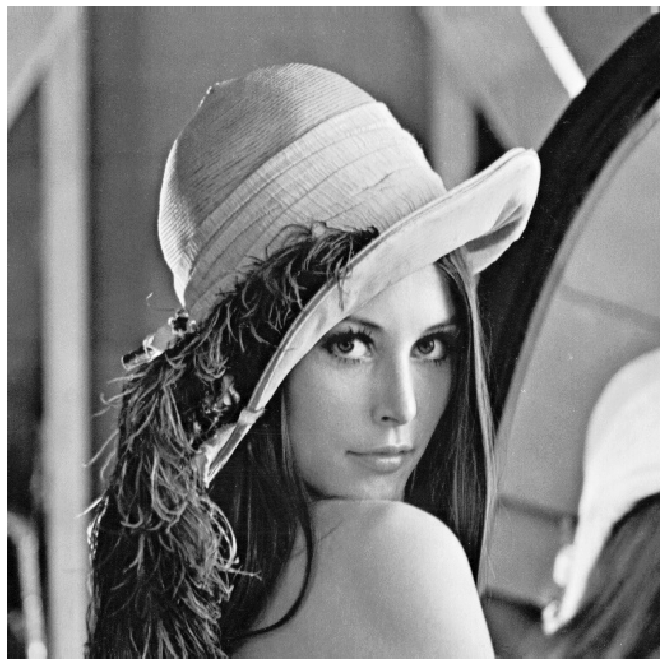

In [2]:
l = imread('lena.png')
plt.imshow(l, cmap='Greys_r')
plt.gcf()
plt.axis('off')
plt.show()

## Add pepper noise to it

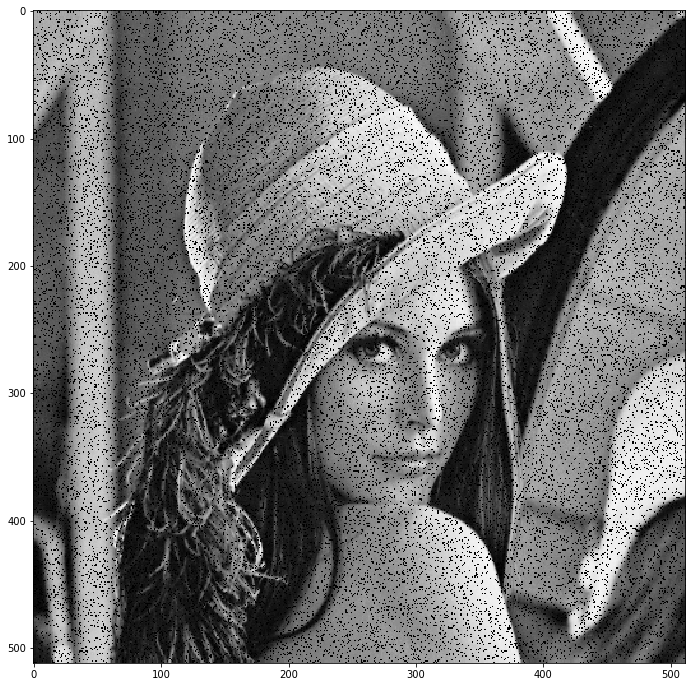

In [3]:
lena_orig = np.array(l).astype(float)
lena_orig /= lena_orig.max()
# Add random black noise in image
lena_noise = random_noise(lena_orig, 'pepper', amount=0.11)
plt.imshow(lena_noise, cmap='Greys_r')
plt.show()

## We use a couple of filters to remove pepper noise

/home/francois/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


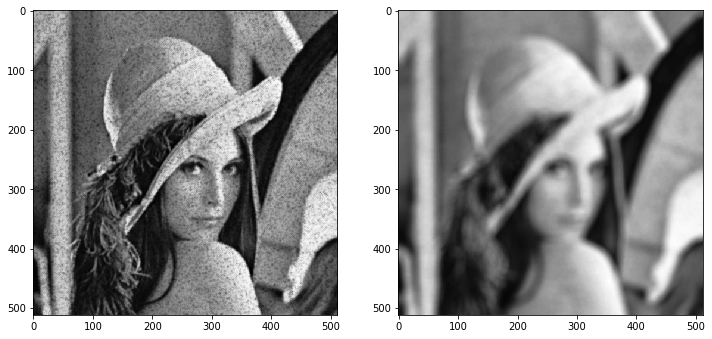

In [4]:
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(mean(lena_noise, disk(2)), cmap='Greys_r')
ax2.imshow(mean(lena_noise, disk(10)), cmap='Greys_r')
plt.show()

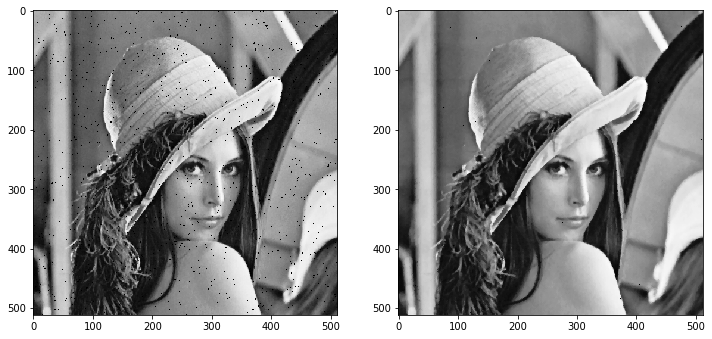

In [5]:
_, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(median(lena_noise, disk(1)), cmap='Greys_r')
ax2.imshow(median(lena_noise, disk(2)), cmap='Greys_r')
plt.show()

# Scikit-image allows for non square/rectagular supports for filters

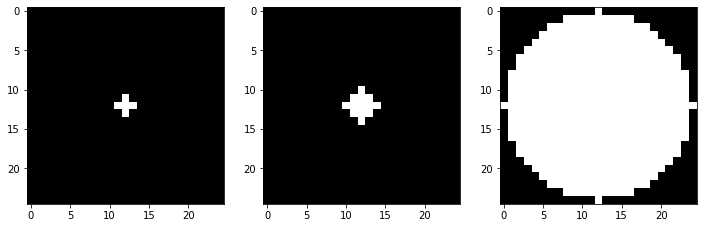

In [6]:
d1 = np.array(disk(1))
d2 = np.array(disk(2))
d12 = np.array(disk(12))
D1 = np.zeros((25,25))
D2 = np.zeros((25,25))
D12 = np.zeros((25,25))
D1[11:14,11:14]=d1
D2[10:15,10:15]=d2
D12 = d12
_,(ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(D1, cmap='Greys_r')
ax2.imshow(D2, cmap='Greys_r')
ax3.imshow(D12, cmap='Greys_r')
plt.show()

# Correlation

In [7]:
crowd = np.array(imread('crowd.png')[:,:,0])
face = np.array(imread('face.png')[:,:,0])
# print(crowd.shape, face.shape)

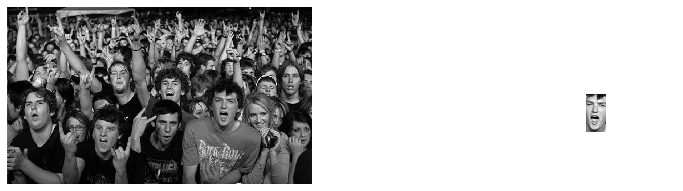

In [8]:
f,ax = plt.subplots(1,2)
ax[0].imshow(crowd, cmap='Greys_r')
# for display purposes
empty = np.ones_like(crowd)*np.max(face)
empty[400-(face.shape[0]//2):400+(face.shape[0]//2)+1,840-(face.shape[1]//2):840+(face.shape[1]//2)+1] = face
ax[1].imshow(empty, cmap='Greys_r')
ax[0].axis('off')
ax[1].axis('off')
plt.show()

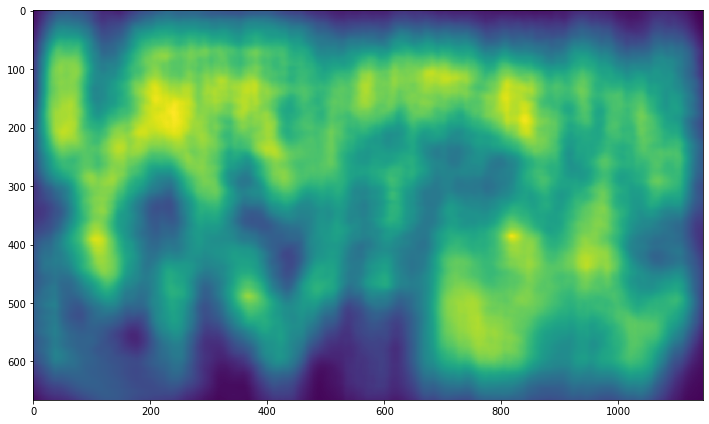

In [10]:
facecor = correlate2d(crowd.astype(float), face.astype(float), mode='same')
plt.imshow(facecor)
plt.show()

In [11]:
def get_local_maxima(img, N):
    # img is a 2D image, N an integer
    # we check whether each (acceptable) pixel is a 
    # local maximum in a (2N+1)x(2N+1) window centered
    # around it
    m,n = img.shape
    locmax = np.zeros_like(img, dtype='uint8')
    for i in range(N, m-N):
        for j in range(N, n-N):
            u = img[i-N:i+N+1,j-N:j+N+1].flatten()
            y = img[i,j]
            u = y - u
            if all([l >= 0 for l in u]):
                locmax[i,j] = 1
    return locmax
    

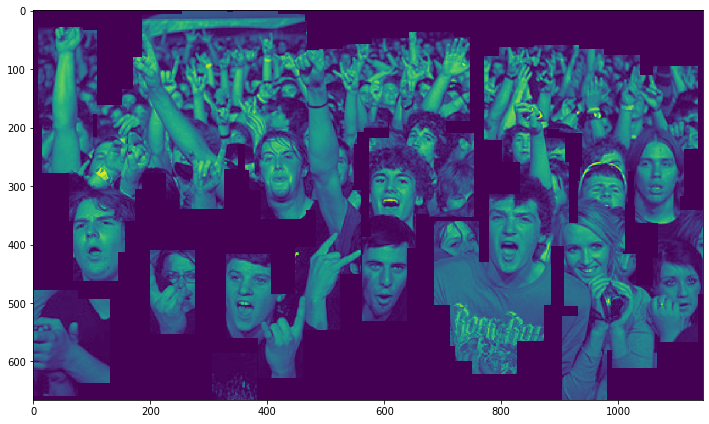

In [12]:
# beware, can take rather long, depending on N
# put want_to_execute to True if you want to run it
want_to_execute = True
if want_to_execute:
    lm = get_local_maxima(facecor, 9)
    bkcrowd = np.zeros_like(crowd)
    fm, fn = face.shape
    fm2 = fm//2
    fn2 = fn//2
    x, y = np.where(lm)
    n = len(x)
    for i in range(n): 
        bkcrowd[x[i]-fm2:x[i]+fm2+1,y[i]-fn2:y[i]+fn2+1] = \
        crowd[x[i]-fm2:x[i]+fm2+1,y[i]-fn2:y[i]+fn2+1]

    plt.imshow(bkcrowd)
    plt.show()

# Edges and noise
### Note that scikit-image random_noise() seems to truncate the noise to fit image range.

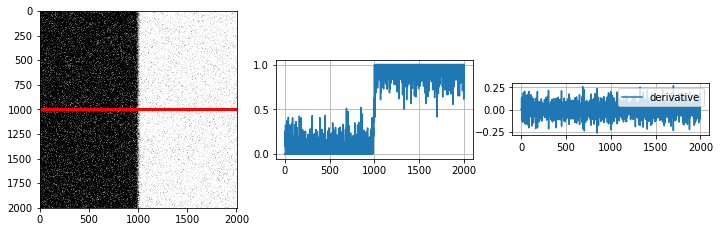

In [13]:
vedge = np.zeros((2001,2001))
vedge[:,1000:] = 1.0
vedge_noisy = random_noise(gaussian(vedge, sigma=15.0), var=0.025)
midline = vedge_noisy[1000,:]
#print(midline.max())
# approximate derivative with central differences
dermidline = 0.5*(midline[1:] - midline[:-1])
_,(ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(vedge_noisy, cmap='Greys_r')
ax1.plot([0, 2000],[1000,1000], 'r', linewidth=3.0)
ax2.plot(midline, label='signal along line')
ax3.plot(dermidline, label='derivative')
ax2.grid('on')
ax3.grid('on')
ax2.set_aspect(1000)
ax3.set_aspect(1000)
plt.legend()
plt.show()

# Edges and convolution

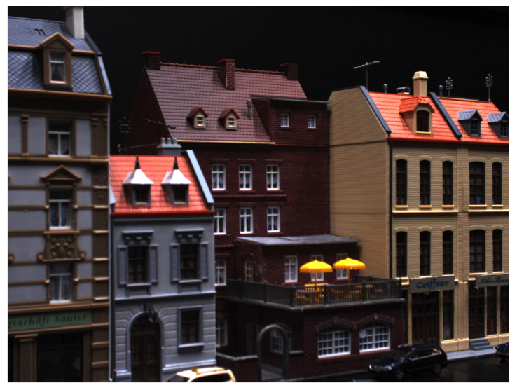

In [14]:
houses = np.array(imread('smkA0b.png'))
plt.figure(figsize=(9,9))
plt.imshow(houses)
plt.axis('off')
plt.show()

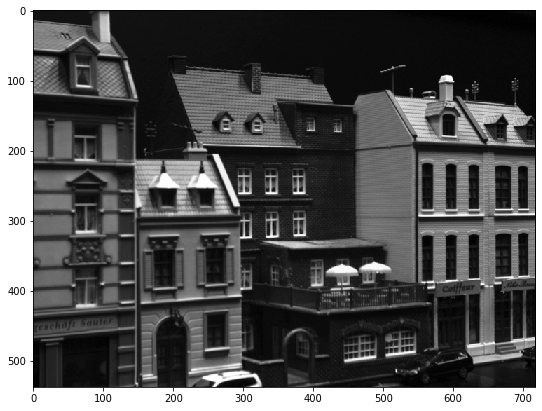

In [15]:
# Conversion to greyscale image with standard weighting

ghouse = 0.2125*houses[:,:,0] + 0.7154*houses[:,:,1] + 0.0721*houses[:,:,2]
plt.figure(figsize=(9,9))
plt.imshow(ghouse, cmap='Greys_r')
plt.show()

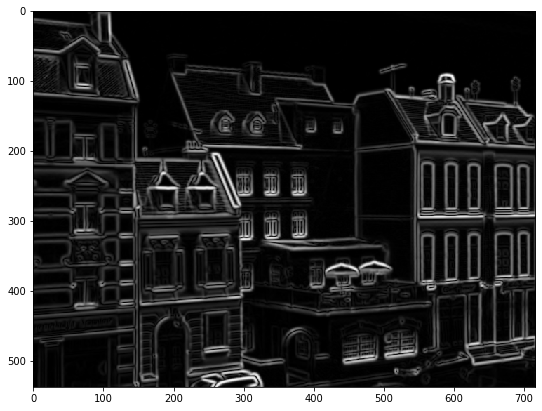

In [16]:
fghouse = gaussian_scalespace(ghouse, sigma=1.5)
gx = 0.5*(fghouse[1:,:] - fghouse[:-1,:])
gy = 0.5*(fghouse[:,1:] - fghouse[:,:-1])
ng = np.sqrt(gx[:,1:]**2 + gy[1:,:]**2)
plt.figure(figsize=(9,9))
plt.imshow(ng , cmap='Greys_r')
plt.show()

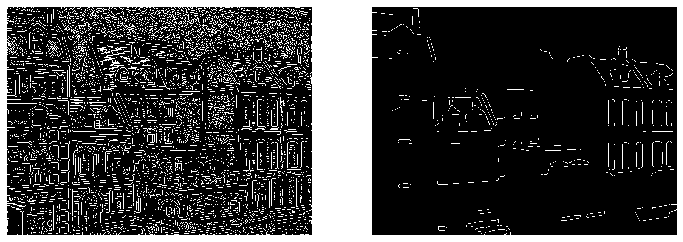

In [17]:
edc1 = canny(fghouse, sigma=1.0)
edc3 = canny(fghouse, sigma=3.0, low_threshold=60.0, high_threshold=80.0)
_,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(edc1, cmap='Greys_r')
ax2.imshow(edc3, cmap='Greys_r')
ax1.axis('off')
ax2.axis('off')
plt.show()

# Elements of Gaussian pyramid

In [18]:
def gderivatives_order3(img, sigma):
    # order is a list of length 2 arrays. first entry of an array means 
    # derivation order in x, second entry means order of derivation in y,
    # First array coordinate is however vertical and secodnd horizontal
    # this is why some of the names below have been kind of switched
    
    order=([0,0],[1,0],[0,1],[2,0],[1,1],[0,2],[3,0],[2,1],[1,2],[0,3])
    
    g00,g01,g10,g02,g11,g20,g03,g12,g21,g30 = gaussian_scalespace(img, sigma, order)
    
    fg = plt.figure(constrained_layout=True)
    gs = fg.add_gridspec(8, 8)
    ax00 = fg.add_subplot(gs[:2,3:5])
    ax10 = fg.add_subplot(gs[2:4,2:4])
    ax01 = fg.add_subplot(gs[2:4,4:6])
    ax20 = fg.add_subplot(gs[4:6,1:3])
    ax11 = fg.add_subplot(gs[4:6,3:5])
    ax02 = fg.add_subplot(gs[4:6,5:7])
    ax30 = fg.add_subplot(gs[6:8,0:2])
    ax21 = fg.add_subplot(gs[6:8,2:4])
    ax12 = fg.add_subplot(gs[6:8,4:6])
    ax03 = fg.add_subplot(gs[6:8,6:8])
    ax00.imshow(g00, cmap='Greys_r')
    ax00.axis('off')
    ax10.imshow(g10, cmap='Greys_r')
    ax10.axis('off')
    ax01.imshow(g01, cmap='Greys_r')
    ax01.axis('off')
    ax20.imshow(g20, cmap='Greys_r')
    ax20.axis('off')
    ax11.imshow(g11, cmap='Greys_r')
    ax11.axis('off')
    ax02.imshow(g02, cmap='Greys_r')
    ax02.axis('off')
    ax30.imshow(g30, cmap='Greys_r')
    ax30.axis('off')
    ax21.imshow(g21, cmap='Greys_r')
    ax21.axis('off')
    ax12.imshow(g12, cmap='Greys_r')
    ax12.axis('off')
    ax03.imshow(g03, cmap='Greys_r')
    ax03.axis('off')
    plt.show()
    

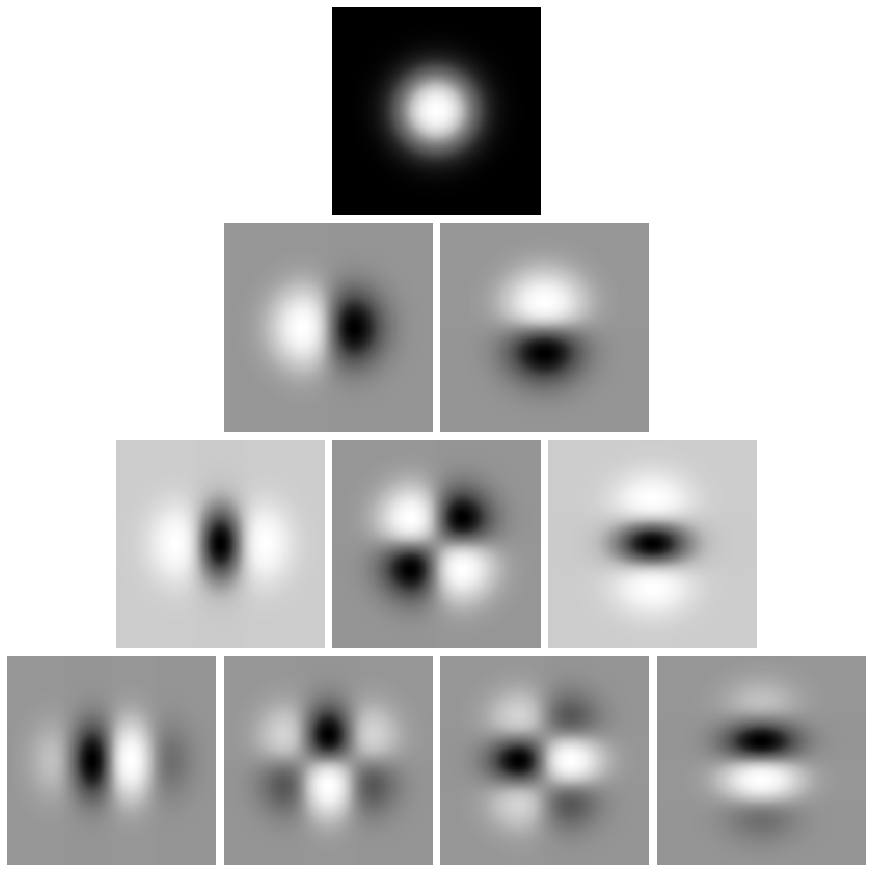

In [19]:
dirac = np.zeros((201,201))
dirac[100,100] = 1.0
gderivatives_order3(dirac, sigma=25.0)

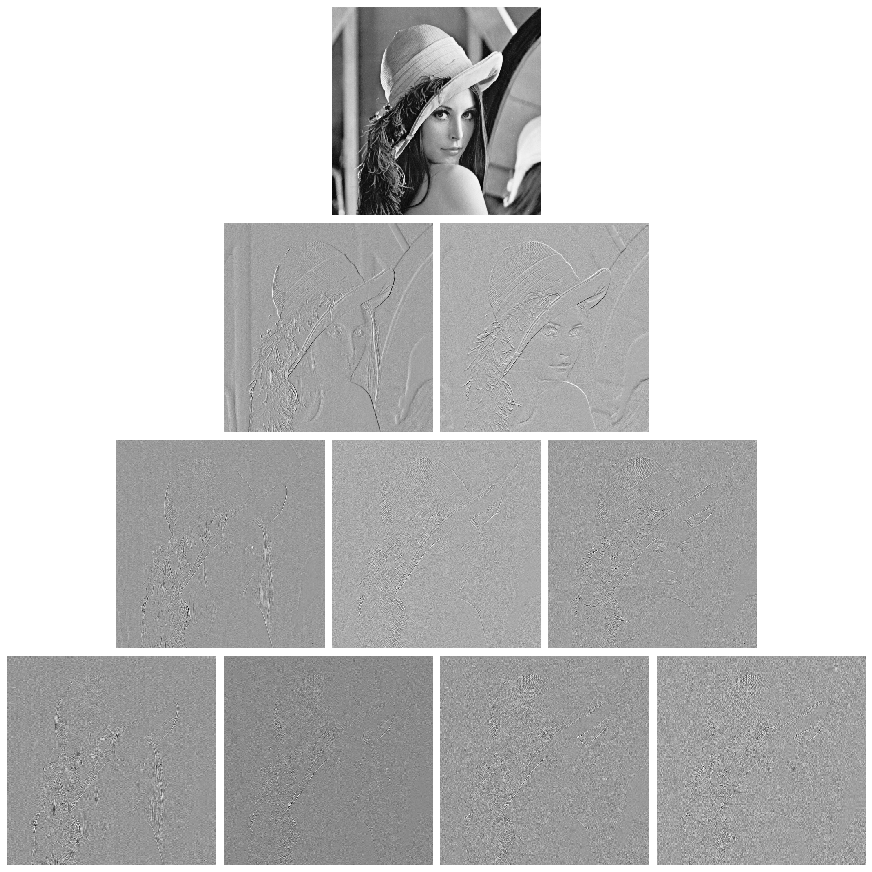

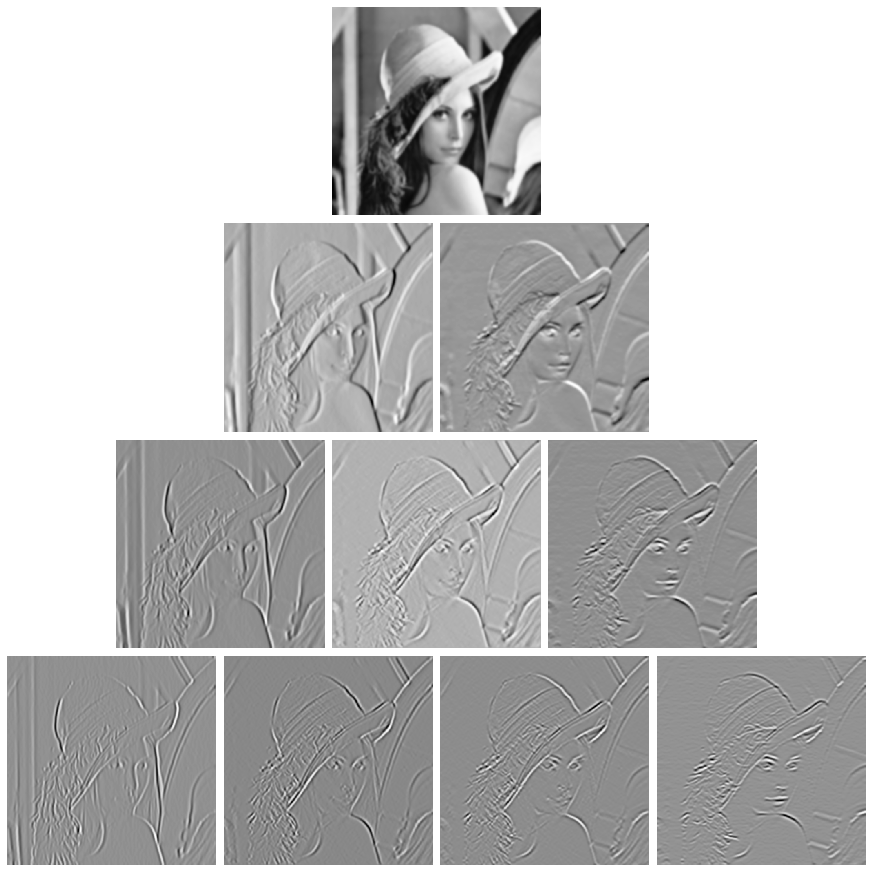

In [20]:
# first with sigma = 0. Derivative quality is fast degrading with order
gderivatives_order3(lena_orig, sigma=0.0)
# Then with sigma = 1, much better
gderivatives_order3(lena_orig, sigma=3.0)

# Marr-Hildreth: use zero-crossings of Laplacian of Gaussian to extract edges

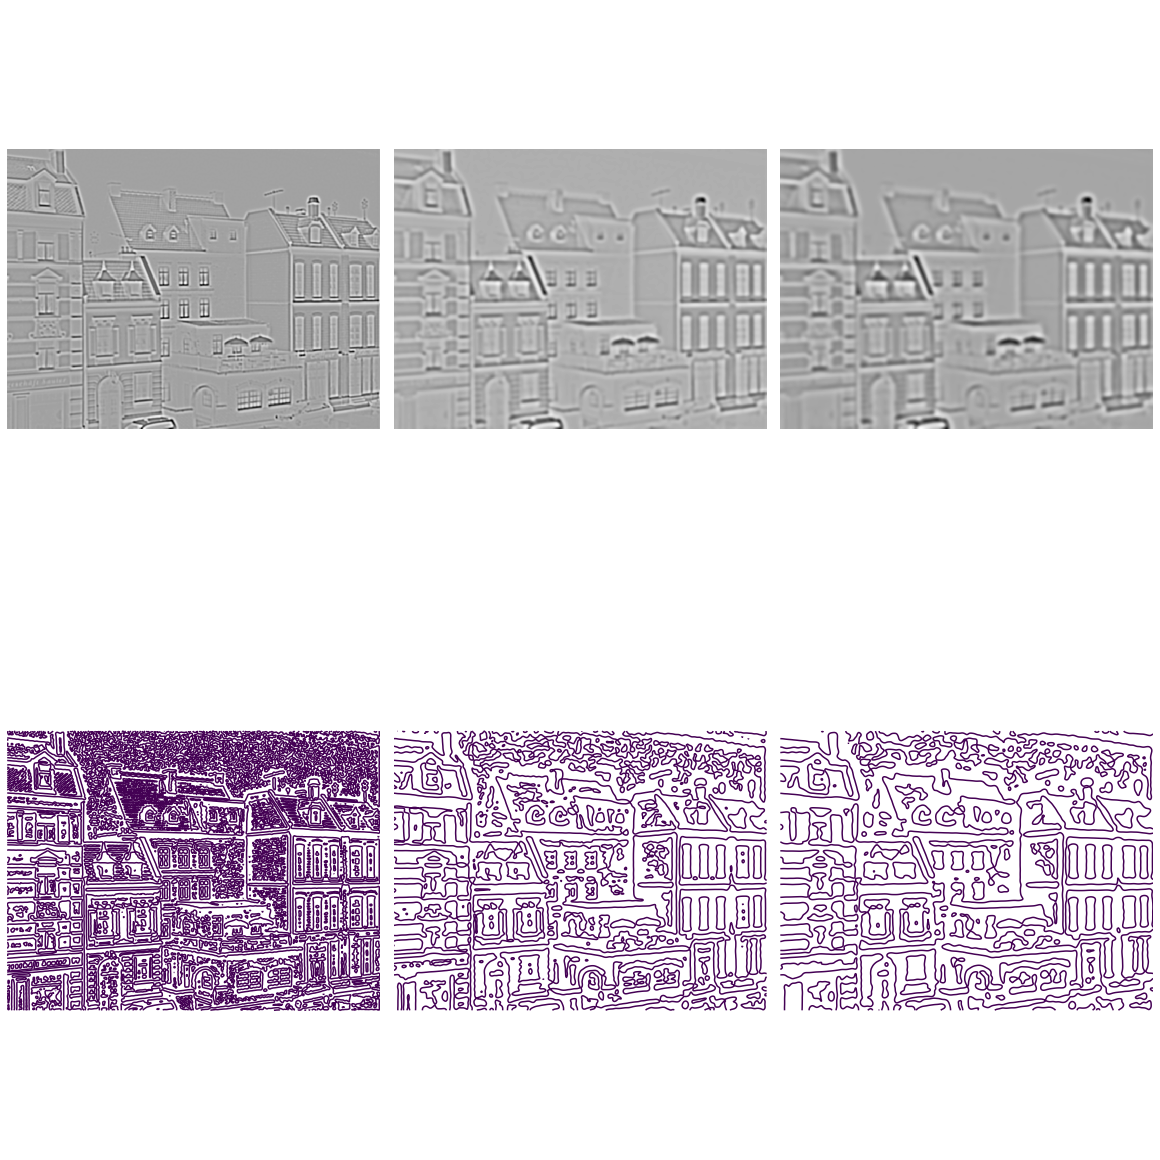

In [54]:
dxx2, dyy2 = gaussian_scalespace(ghouse, sigma=2.0, order=[[2,0],[0,2]])
laphouse2 = dxx2 + dyy2
dxx4, dyy4 = gaussian_scalespace(ghouse, sigma=4.0, order=[[2,0],[0,2]])
laphouse4 = dxx4 + dyy4
dxx5, dyy5 = gaussian_scalespace(ghouse, sigma=5.0, order=[[2,0],[0,2]])
laphouse5 = dxx5 + dyy5


m,n = ghouse.shape
X, Y = np.mgrid[0:m,0:n]
f = plt.figure(constrained_layout=True)
gs = f.add_gridspec(2, 3)
f.set_size_inches(16,16)
ax2 = f.add_subplot(gs[0,0])
ax4 = f.add_subplot(gs[0,1])
ax5 = f.add_subplot(gs[0,2])
lax2 = f.add_subplot(gs[1,0])
lax4 = f.add_subplot(gs[1,1])
lax5 = f.add_subplot(gs[1,2])

ax = (ax2, ax4, ax5, lax2, lax4, lax5)

ax2.imshow(laphouse2, cmap='Greys_r')
ax4.imshow(laphouse4, cmap='Greys_r')
ax5.imshow(laphouse5, cmap='Greys_r')

lax2.contour(Y,-X, laphouse2, [0.0])
lax4.contour(Y,-X, laphouse4, [0.0])
lax5.contour(Y,-X, laphouse5, [0.0])
for item in ax:
    item.axis('off')
    item.axis('equal')
plt.show()

In [21]:
H = structure_tensor(ghouse, innerscale=2.0, outerscale=3.0)

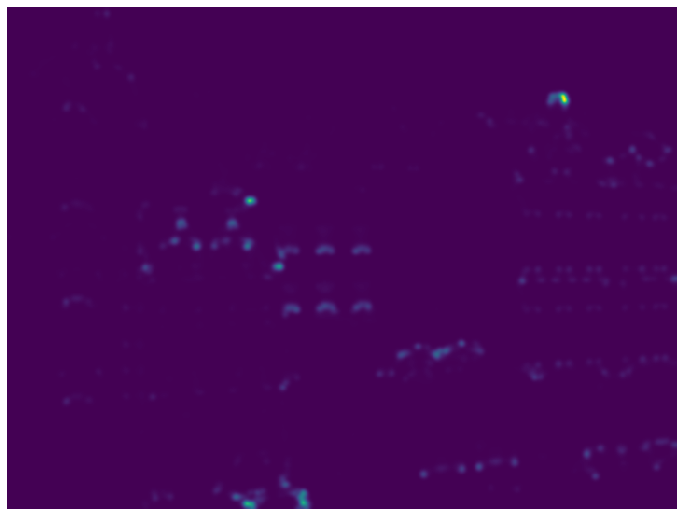

In [22]:
k = 0.15
harris_house = determinant_symmetric_field(H) - k*trace_symmetric_field(H)
plt.imshow(harris_house)
plt.axis('off')
plt.show()

In [24]:
sl = get_local_maxima(harris_house, N=6)

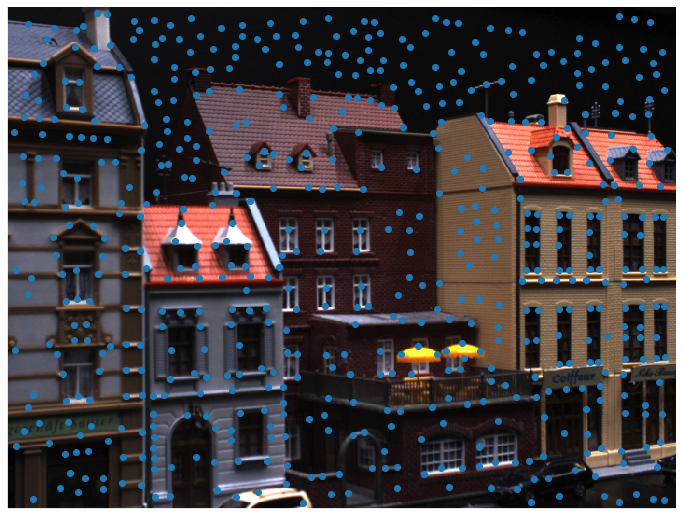

In [25]:
plt.imshow(houses)
idx = np.where(sl)
y, x = idx
plt.scatter(x, y)
plt.axis('off')
plt.show()